In [1]:
# --- Imports and Setup ---
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings


warnings.filterwarnings('ignore')




In [2]:
data_folder = 'data'
datasets = []

for folder in os.listdir(data_folder):
    folder_path = os.path.join(data_folder, folder)
    if os.path.isdir(folder_path):
        for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)
            if file.endswith('.csv'):
                print(f"Loading: {file}")
                dataset = pd.read_csv(file_path)
                datasets.append(dataset)

full_data = pd.concat(datasets, ignore_index=True)

if 'ActualTime' in full_data.columns:
    full_data_ = full_data.drop(columns=['ActualTime'])
else:
    full_data_ = full_data.copy()

Loading: AnushkaSittingDCwBuffer.csv
Loading: AnushkaSittingDWwBuffer.csv
Loading: AnushkaSittingScrollingwBuffer.csv
Loading: AnushkaSittingTalkingwBuffer.csv
Loading: AnushkaSittingTypingwBuffer.csv
Loading: AnushkaSittingWritingwBuffer.csv
Loading: AnushkaStandingDCwBuffer.csv
Loading: AnushkaStandingErasingwBuffer.csv
Loading: AnushkaStandingTalkingwBuffer.csv
Loading: AnushkaStandingWBwBuffer.csv
Loading: MohitSittingDrinkingWaterwBuffer.csv
Loading: MohitSittingScrollingwBuffer.csv
Loading: MohitSittingTalkingwBuffer.csv
Loading: MohitSittingTypingwBuffer.csv
Loading: MohitSittingWritingwBuffer.csv
Loading: MohitStandingDrinkingWaterwBuffer.csv
Loading: MohitStandingErasingwBuffer.csv
Loading: MohitStandingTalkingwBuffer.csv
Loading: MohitStandingWritingwBuffer.csv
Loading: SaiScrollingOnPhonewBuffer.csv
Loading: SaiSittingDWwBuffer.csv
Loading: SaiSittingTalkingwBuffer.csv
Loading: SaiSittingTypingwBuffer.csv
Loading: SaiSittingWritingwBuffer.csv
Loading: SaiStandingDWwoBuffer.c

In [3]:
sensor_features = [
    'Ax watch', 'Ay watch', 'Az watch', 'Gx watch', 'Gy watch', 'Gz watch',
    'Ax esense', 'Ay esense', 'Az esense', 'Gx esense', 'Gy esense', 'Gz esense'
]

In [4]:
for col in sensor_features:
    full_data_[col] = pd.to_numeric(full_data_[col], errors='coerce')
    



In [5]:
full_data_ = full_data_.dropna(subset=sensor_features + ['Combined_Action_Num'])

In [6]:


# If you want to use windowed statistics:
def extract_features(df, window_size=50, step=25):
    features = []
    labels = []
    for start in range(0, len(df) - window_size + 1, step):
        window = df.iloc[start:start+window_size]
        feats = []
        for col in sensor_features:
            feats.extend([
                window[col].mean(),
                window[col].std(),
                window[col].min(),
                window[col].max(),
                window[col].median(),
            ])
        # Use the mode of the label in the window as the target
        label = window['Combined_Action_Num'].mode()[0]
        features.append(feats)
        labels.append(label)
    return np.array(features), np.array(labels)

X, y = extract_features(full_data_)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [8]:
import numpy as np
print(np.unique(y_train))
print(np.unique(y_test))


[ 0  1  2  3  4  5  7  8  9 10 11]
[ 0  1  2  3  4  5  7  8  9 10 11]


In [9]:
from sklearn.preprocessing import LabelEncoder


# Encode the activity labels as consecutive integers for model compatibility
# This ensures the class labels are mapped to 0, 1, ..., n-1, which is required by XGBoost and many other classifiers.
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)  # Fit on training labels and transform them
y_test_enc = le.transform(y_test)        # Transform test labels using the same mapping


In [12]:
num_classes = len(np.unique(y_train))
print(num_classes)

11


In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix




model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=num_classes,
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)

model.fit(X_train, y_train_enc)

y_pred_enc = model.predict(X_test)

y_pred = le.inverse_transform(y_pred_enc)  


# # Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.4f}")

# Detailed report
print(classification_report(y_test, y_pred))


Test Accuracy: 0.9302
              precision    recall  f1-score   support

           0       0.87      0.96      0.92        28
           1       0.97      1.00      0.99        34
           2       0.93      0.97      0.95        39
           3       0.94      0.89      0.91        35
           4       0.86      0.83      0.84        29
           5       0.94      1.00      0.97        33
           7       0.94      0.86      0.90        35
           8       0.97      0.94      0.95        31
           9       0.88      0.81      0.84        26
          10       0.90      1.00      0.95        19
          11       1.00      0.97      0.99        35

    accuracy                           0.93       344
   macro avg       0.93      0.93      0.93       344
weighted avg       0.93      0.93      0.93       344



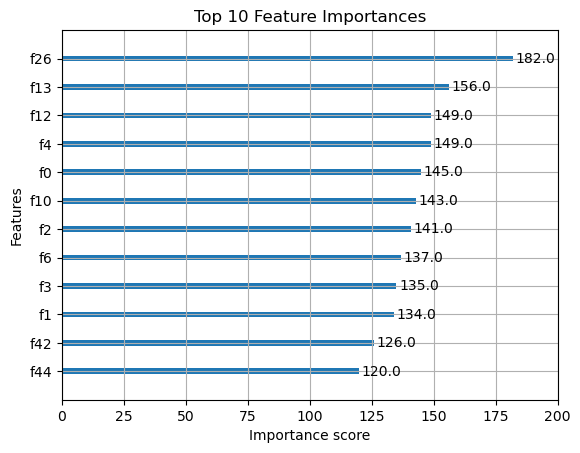

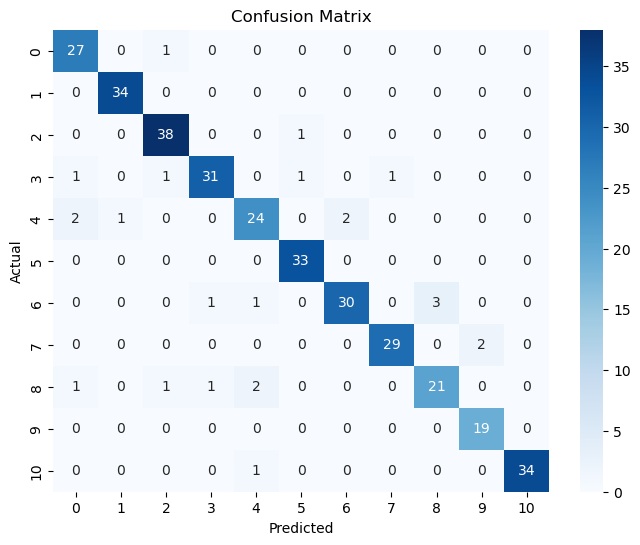

In [13]:

xgb.plot_importance(model, max_num_features=12)
plt.title("Top 10 Feature Importances")
plt.show()


cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [14]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200],
}


grid = GridSearchCV(
    xgb.XGBClassifier(objective='multi:softmax', num_class=12),
    param_grid,
    cv=6
)


grid.fit(X_train, y_train_enc )
print(grid.best_params_)


{'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200}


In [34]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, X_train, y_train_enc, cv=5, scoring='accuracy')
print(f"Cross-validation accuracy: {scores.mean():.4f} ± {scores.std():.4f}")


Cross-validation accuracy: 0.9119 ± 0.0122


In [35]:
import joblib

# Save the trained model
joblib.dump(model, 'xgboost_activity_model.pkl')


['xgboost_activity_model.pkl']

In [36]:
# # Save using XGBoost's built-in method
# model.save_model('xgboost_activity_model.json')

# # To load:
# # import xgboost as xgb
# # model = xgb.XGBClassifier()
# # model.load_model('xgboost_activity_model.json')
